In [1]:
import os # For checking current work directory
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
import warnings
from scipy.stats import t
from py_markdown_table.markdown_table import markdown_table

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


             Dose    Response
0        1.258925    9.427569
1        1.681284    5.409299
2        2.245340    7.258125
3        2.998631   11.218594
4        4.004646   10.365896
5        5.348169    2.241011
6        7.142433    8.648426
7        9.538656    6.293143
8       12.738791    7.865314
9       17.012543   11.526454
10      22.720101   13.812730
11      30.342495   22.110383
12      40.522134   25.968580
13      54.116953   31.700761
14      72.272713   41.867311
15      96.519571   51.726045
16     128.901037   65.512858
17     172.146198   69.924342
18     229.899730   79.538538
19     307.029063   82.390310
20     410.034607   82.021688
21     547.597603   95.011497
22     731.311772   97.972748
23     976.660424   94.728029
24    1304.321387  104.813674
25    1741.909714   94.334337
26    2326.305067   99.289233
27    3106.759910   98.887249
28    4149.050472  104.240467
29    5541.020330  104.175891
30    7399.983804  100.314271
31    9882.613137  101.036871
32   13198

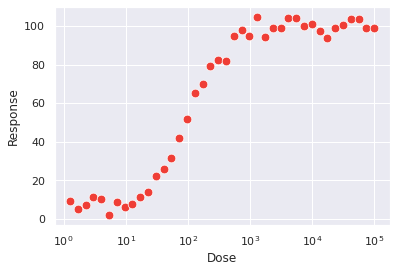

In [2]:
# Import data #
toxin_df = pd.read_csv('Toxin.csv')

# Inspect data #
sns.set_theme()
sns.scatterplot(data = toxin_df, x = 'Dose', y = 'Response', color = ['#ef3e36'], s = 75).set_xscale("log")
print(toxin_df)

In [87]:
# Note: 
# 1. We shoud include 'data' in the object instantiation (see below for example) for all functions
# 2. The users should only need to reference the varibles of interest in strings (see changes below; x_name and y_name
# 3. Added a placeholder argumented called 'summary' for printing estimated parameters (in Pandas DataFrame)
# 4. Added Overflow warnings, which is turned off during parameter optimization
# 5. Two-sided t-test for the parameter estimates
# 6. Add astirisk to p-value?

import warnings
import math
import numpy as np
from scipy import stats # For t-tests
from scipy.optimize import curve_fit # Parameter optimization

class LogisticP4Model:
    def __init__(self, data = None, x = None, y = None, param_constraint = None):
        self.params = None
        self.data = data
        self.x = x
        self.y = y
        self.param_constraint = np.array(param_constraint)

    def logistic_P4(self, x, b, c, d, e):
        """Calculate log-logistic curve (4-parameter model) at a given point"""
        f = c + (d - c) / (1 + np.exp(b * (np.log(x) - np.log(e))))
        return f

    def fit(self, x = None, y = None, summary = True, keep_summary = False, param_constraint = None, n_dec = 6):
        """Estimate parameters (b, c, d, e) of the log-logistic curve from data"""
        if self.x is None and x is None:
            raise ValueError("Warning: No valid parameter provided for the X-axis. Please ensure that the parameter supplied is a numeric array containing valid numerical values.")
        if self.y is None and y is None:
            raise ValueError("Warning: No valid parameter provided for the Y-axis. Please ensure that the parameter supplied is a numeric array containing valid numerical values.")          
        if self.x is None:
            x_data = self.data[x]
            self.x = x
        else:
            x_data = self.data[self.x]
        if self.y is None:
            y_data = self.data[y]
            self.y = y
        else:
            y_data = self.data[self.y]
            
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        
        if len(np.shape(self.param_constraint)) == 1:
            lower_bound = np.where(self.param_constraint == np.inf, -np.inf, self.param_constraint - 1e-14)
            upper_bound = np.where(self.param_constraint == np.inf, np.inf, self.param_constraint + 1e-14)
            mod_bounds = (np.array(lower_bound), np.array(upper_bound))
        elif len(np.shape(self.param_constraint)) == 2:
            lower_bound = np.where(self.param_constraint[0] == np.inf, -np.inf, self.param_constraint[0] - 1e-14)
            upper_bound = np.where(self.param_constraint[1] == np.inf, np.inf, self.param_constraint[1] + 1e-14)
            mod_bounds = (np.array(lower_bound), np.array(upper_bound))
        else:
            mod_bounds = (-np.inf, np.inf)
        
        params, covariance = curve_fit(self.logistic_P4, x_data, y_data, bounds = mod_bounds)
        warnings.filterwarnings("default", category=RuntimeWarning)
        
        self.params = np.round(params, decimals = n_dec)
        self.std_error = np.sqrt(np.diag(covariance))
        if summary == True:
            summary_params = pd.DataFrame({'Parameter': ['b', 'c', 'd', 'e'],
                                           'Estimate': self.params,
                                           'Std. Error': self.std_error,
                                           't-value': self.params / self.std_error,
                                           'p-value': (1 - stats.t(df = len(y_data) - len(self.params)).cdf(x = self.params / self.std_error)) * 2
                                            })
        if keep_summary == True:
            return summary_params
        else:
            print(summary_params)
          
    def predict(self, x = None):
        """Predict output of log-logistic curve"""
        if self.params is None:
            raise ValueError("Parameters not estimated. Call fit() first.")
        if x is None:
            x_pred = self.data[self.x]
        else:
            x_pred = x
        b, c, d, e = self.params
        return self.logistic_P4(x_pred, b, c, d, e)

In [92]:
#toxin_mod = LogisticP4Model(data = toxin_df, x = 'Dose', y = 'Response')
#summary_table = toxin_mod.fit(keep_summary = True)
#summary_table
#toxin_mod = LogisticP4Model(data = toxin_df, x = 'Dose', y = 'Response', param_constraint = [1.5, 100, 0, np.inf])
#summary_table = toxin_mod.fit(keep_summary = True)
#summary_table
toxin_mod = LogisticP4Model(data = toxin_df, x = 'Dose', y = 'Response', param_constraint = [[0.5, 100, 0, np.inf],[1.5, 110, 10, np.inf]])
summary_table = toxin_mod.fit(keep_summary = True)
summary_table

,Parameter,Estimate,Std. Error,t-value,p-value
0,b,1.467722,0.089680,16.366215,0.000000
1,c,100.320995,0.817863,122.662304,0.000000
2,d,6.261730,1.208824,5.180016,0.000009
3,e,101.744509,4.820494,21.106657,0.000000


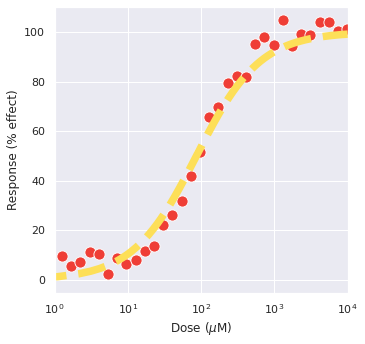

In [66]:
import numpy as np

X = np.linspace(0.1, 10000, 10000)

toxin_mod.predict(x = X) # If no x argument is given -> The model X-values will be used as default 

plt.figure(figsize = (5.25, 5.25), frameon = False)
plt.plot(X, toxin_mod.predict(x = X), color='#fddf58', linestyle='--', linewidth=7.5)
sns.scatterplot(data = toxin_df, x = 'Dose', y = 'Response', color = ['#ef3e36'], s = 125).set_xscale("log")
plt.xlim(1, 10000)  # Example x-axis limits
plt.xlabel(r'Dose ($\mu$M)')  # Example of using Greek letter alpha
plt.ylabel(r'Response (% effect)')   # Example of using Greek letter beta

plt.savefig(fname = 'Hello_pydrc.png',dpi = 1000, format = 'png')

array([  1., -inf, -inf, -inf])